<a href="https://colab.research.google.com/github/venkateshakula1729/GenAI-Fusion/blob/main/FineTuning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries


In [ ]:
import numpy as np
import pandas as pd
import json

from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer
import seaborn as sns
from tqdm import tqdm

# Initialize GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load the data
with open('jokes.json', 'r') as file:
    jokes_data = json.load(file)
df = pd.DataFrame(jokes_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Create Co-occurrence Matrix with Memory Optimization


In [ ]:
from scipy.sparse import lil_matrix
import numpy as np
from collections import defaultdict

def create_cooccurrence_matrix(texts, max_vocab_size=10000, window_size=2):
    # First pass: count word frequencies
    word_freq = defaultdict(int)
    print("Counting word frequencies...")
    for text in tqdm(texts):
        tokens = tokenizer.tokenize(str(text))
        for token in tokens:
            word_freq[token] += 1

    # Select top words by frequency
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_words = top_words[:max_vocab_size]

    # Create word to index mapping
    word_to_idx = {word: idx for idx, (word, _) in enumerate(top_words)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    # Initialize sparse co-occurrence matrix
    vocab_size = len(word_to_idx)
    cooccurrence_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float32)

    # Second pass: fill co-occurrence matrix
    print("Creating co-occurrence matrix...")
    for text in tqdm(texts):
        tokens = tokenizer.tokenize(str(text))
        # Convert tokens to indices, ignoring tokens not in vocabulary
        indices = [word_to_idx[token] for token in tokens if token in word_to_idx]

        for i, center_word_idx in enumerate(indices):
            # For each word in window
            window_start = max(0, i - window_size)
            window_end = min(len(indices), i + window_size + 1)
            for j in range(window_start, window_end):
                if i != j:
                    context_word_idx = indices[j]
                    cooccurrence_matrix[center_word_idx, context_word_idx] += 1

    return cooccurrence_matrix.tocsr(), word_to_idx, idx_to_word

# Create co-occurrence matrix
print("Processing texts...")
texts = df['title'] + " " + df['body']  # Combine title and body
cooccurrence_matrix, word_to_idx, idx_to_word = create_cooccurrence_matrix(
    texts,
    max_vocab_size=10000,  # We limit vocabulary size due to memory limitations
    window_size=2
)
print(f"Vocabulary size: {len(word_to_idx)}")

Processing texts...
Counting word frequencies...


100%|██████████| 10019/10019 [00:18<00:00, 540.85it/s] 


Creating co-occurrence matrix...


100%|██████████| 10019/10019 [01:52<00:00, 89.23it/s] 


Vocabulary size: 10000


### Apply PCA


In [ ]:
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np

def reduce_dimensions(matrix, n_components=2):
    """Reduce dimensions of co-occurrence matrix using memory-efficient approach"""
    # Convert to sparse matrix if not already
    if not isinstance(matrix, csr_matrix):
        matrix = csr_matrix(matrix)

    print("Normalizing matrix...")
    # Normalize the matrix (using sparse operations)
    matrix_normalized = normalize(matrix, norm='l2', axis=1)

    print("Converting to dense matrix...")
    # Convert to dense only for the final PCA step
    # We take only top 10000 most frequent words if matrix is too large
    if matrix.shape[0] > 10000:
        row_sums = np.array(matrix.sum(axis=1)).flatten()
        top_indices = np.argsort(row_sums)[-10000:]
        matrix_dense = matrix_normalized[top_indices].toarray()
    else:
        matrix_dense = matrix_normalized.toarray()

    print("Applying PCA...")
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_matrix = pca.fit_transform(matrix_dense)

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")

    return reduced_matrix

# Reduce dimensions with progress information
print("Starting dimensionality reduction...")
print("Matrix shape:", cooccurrence_matrix.shape)
embeddings_2d = reduce_dimensions(cooccurrence_matrix)
print("Reduction completed!")

Starting dimensionality reduction...
Matrix shape: (10000, 10000)
Normalizing matrix...
Converting to dense matrix...
Applying PCA...
Explained variance ratio: [0.11969589 0.04797339]
Reduction completed!


###  Visualize Embeddings


Plotting embeddings...


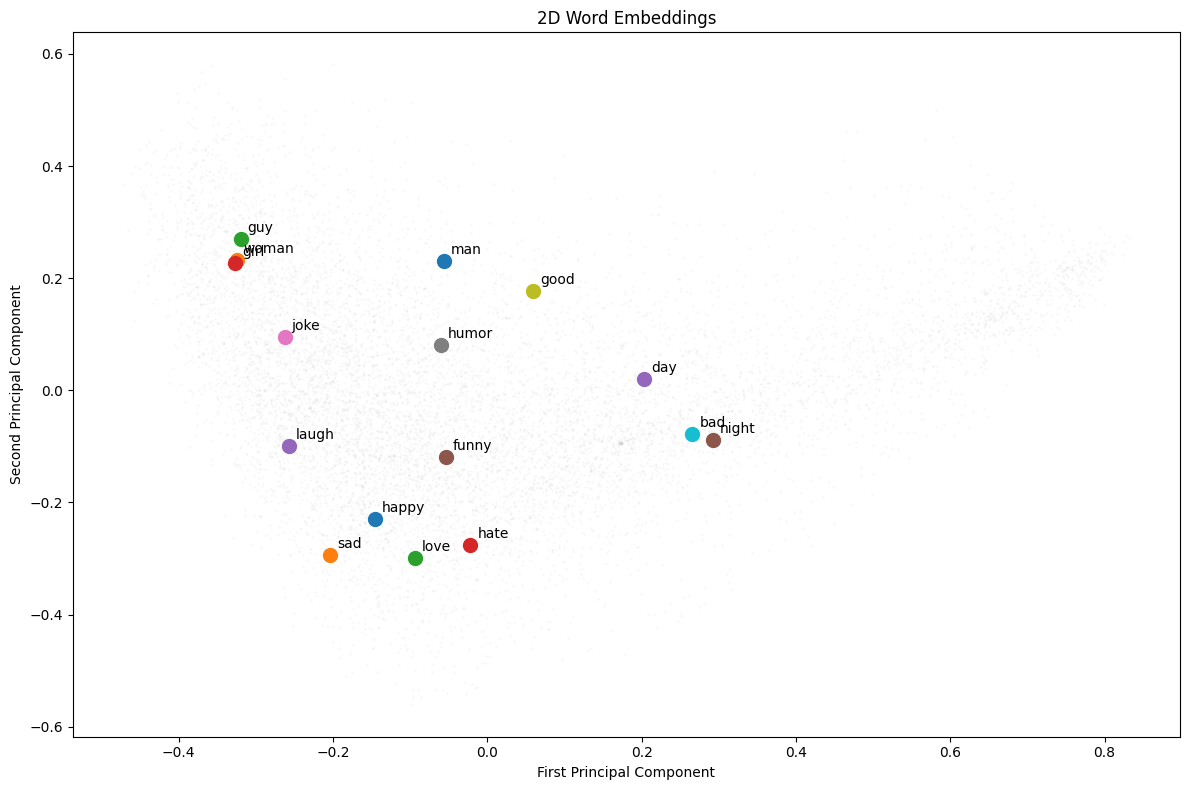

In [ ]:
def plot_embeddings(embeddings, word_to_idx, words_to_plot):
    plt.figure(figsize=(12, 8))

    # Plot all words as background (small gray dots)
    plt.scatter(embeddings[:, 0], embeddings[:, 1],
                c='lightgray', alpha=0.1, s=1)

    # Plot selected words
    plotted_words = []
    for word in words_to_plot:
        # Try different forms of the word (with Ġ prefix and without)
        possible_forms = [word, 'Ġ' + word, ' ' + word]
        for form in possible_forms:
            if form in word_to_idx:
                idx = word_to_idx[form]
                plt.scatter(embeddings[idx, 0], embeddings[idx, 1],
                           s=100)
                plt.annotate(word,
                            (embeddings[idx, 0], embeddings[idx, 1]),
                            xytext=(5, 5),
                            textcoords='offset points')
                plotted_words.append(word)
                break

    # Print words that couldn't be found
    not_found = set(words_to_plot) - set(plotted_words)
    if not_found:
        print(f"Words not found in vocabulary: {not_found}")

    plt.title("2D Word Embeddings")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.tight_layout()
    plt.show()

# Words to visualize (these are some common words likely to appear in jokes)
interesting_words = [
    'man', 'woman', 'guy', 'girl',
    'laugh', 'funny', 'joke', 'humor',
    'good', 'bad', 'happy', 'sad',
    'love', 'hate', 'day', 'night'
]

# Plot embeddings
print("Plotting embeddings...")
plot_embeddings(embeddings_2d, word_to_idx, interesting_words)

### Compare with Pre-trained Embeddings


Loading pre-trained Word2Vec embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded

Comparing embeddings...

Comparison Results:
     word_pair  our_similarity  pretrained_similarity
0    man-woman             NaN               0.766401
1   king-queen             NaN               0.651096
2     good-bad        0.035029               0.719005
3    happy-sad             NaN               0.535461
4    love-hate             NaN               0.600396
5    day-night        0.923551               0.507001
6  funny-laugh             NaN               0.628681
7   joke-humor             NaN               0.475230


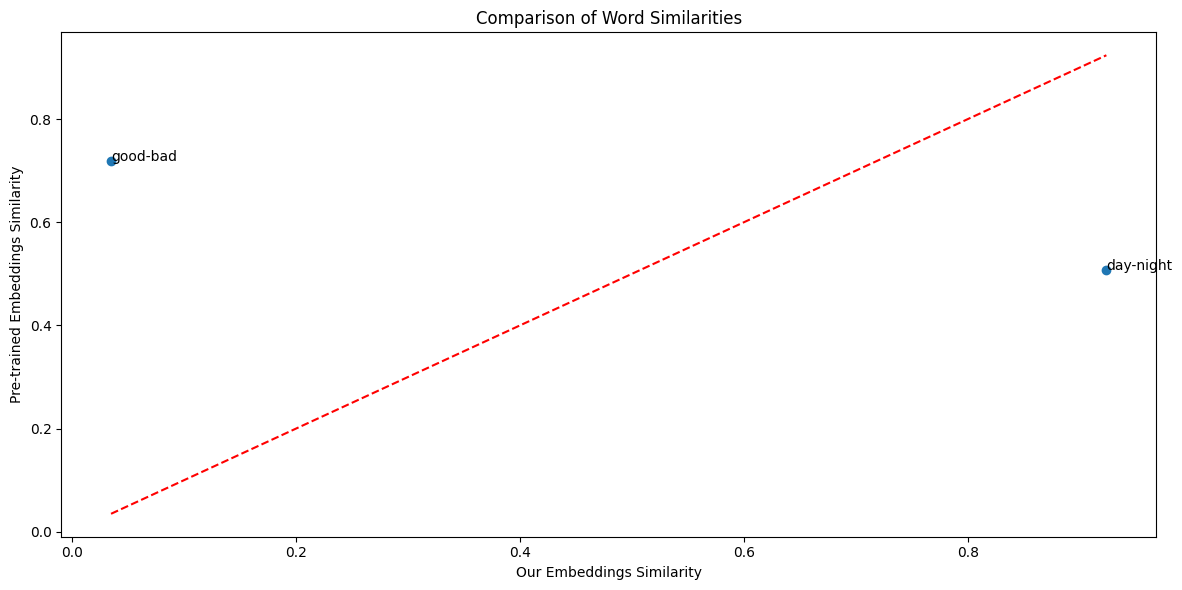

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def load_pretrained_embeddings():
    #Load pre-trained Word2Vec embeddings
    print("Loading pre-trained Word2Vec embeddings...")
    # Download if not already present
    try:
        word2vec = KeyedVectors.load_word2vec_format(
            'GoogleNews-vectors-negative300.bin.gz', binary=True
        )
    except FileNotFoundError:
        print("Downloading Word2Vec embeddings...")
        import gensim.downloader as api
        word2vec = api.load('word2vec-google-news-300')

    return word2vec

def compare_embeddings(our_embeddings, word_to_idx, pretrained_model, word_pairs):
    """Compare similarities between my embeddings and pre-trained embeddings"""
    results = []

    for word1, word2 in word_pairs:
        # Get similarities from our embeddings
        if word1 in word_to_idx and word2 in word_to_idx:
            idx1, idx2 = word_to_idx[word1], word_to_idx[word2]
            our_vec1, our_vec2 = our_embeddings[idx1], our_embeddings[idx2]
            our_similarity = cosine_similarity([our_vec1], [our_vec2])[0][0]
        else:
            our_similarity = None

        # Get similarities from pre-trained embeddings
        try:
            pretrained_similarity = pretrained_model.similarity(word1, word2)
        except KeyError:
            pretrained_similarity = None

        results.append({
            'word_pair': f"{word1}-{word2}",
            'our_similarity': our_similarity,
            'pretrained_similarity': pretrained_similarity
        })

    return pd.DataFrame(results)

def plot_similarity_comparison(comparison_df):
    """Plot comparison of similarities"""
    plt.figure(figsize=(12, 6))

    # Filter out None values
    valid_comparisons = comparison_df.dropna()

    # Create scatter plot
    plt.scatter(valid_comparisons['our_similarity'],
               valid_comparisons['pretrained_similarity'])

    # Add word pair labels
    for idx, row in valid_comparisons.iterrows():
        plt.annotate(row['word_pair'],
                    (row['our_similarity'], row['pretrained_similarity']))

    # Add diagonal line for reference
    max_val = max(valid_comparisons['our_similarity'].max(),
                 valid_comparisons['pretrained_similarity'].max())
    min_val = min(valid_comparisons['our_similarity'].min(),
                 valid_comparisons['pretrained_similarity'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Our Embeddings Similarity')
    plt.ylabel('Pre-trained Embeddings Similarity')
    plt.title('Comparison of Word Similarities')
    plt.tight_layout()
    plt.show()

# Word pairs to compare
comparison_pairs = [
    ('man', 'woman'),
    ('king', 'queen'),
    ('good', 'bad'),
    ('happy', 'sad'),
    ('love', 'hate'),
    ('day', 'night'),
    ('funny', 'laugh'),
    ('joke', 'humor')
]

# Load pre-trained embeddings
word2vec = load_pretrained_embeddings()

# Compare embeddings
print("\nComparing embeddings...")
comparison_results = compare_embeddings(
    embeddings_2d,
    word_to_idx,
    word2vec,
    comparison_pairs
)

# Display results
print("\nComparison Results:")
print(comparison_results)

# Plot comparison
plot_similarity_comparison(comparison_results)

In [ ]:
# Save Results
def save_embeddings(embeddings, word_to_idx, filename='joke_word_embeddings.csv'):
    # Create DataFrame with words and their embeddings
    embedding_df = pd.DataFrame(
        embeddings,
        index=word_to_idx.keys(),
        columns=['dim1', 'dim2']
    )

    # Save to CSV
    embedding_df.to_csv(filename)
    print(f"Embeddings saved to {filename}")

    return embedding_df

# Save embeddings
embeddings_df = save_embeddings(embeddings_2d, word_to_idx)
print("\nSample of saved embeddings:")
print(embeddings_df.head())

Embeddings saved to joke_word_embeddings.csv

Sample of saved embeddings:
          dim1      dim2
č     0.786484  0.212088
Ċ     0.747901  0.228918
.     0.614340  0.328440
,    -0.221871  0.024725
Ġthe -0.239422 -0.314672
